In [1]:
import numpy as np
import talib
import pandas as pd
import os
import talib as ta
import time
import datetime

## Keras for deep learning
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional
from keras.models import Sequential

## Scikit learn for mapping metrics
from sklearn.metrics import mean_squared_error

#for logging
import time

##matrix math
import math

##plotting
import matplotlib.pyplot as plt


#change working directory
os.chdir("D:/Graduate Courses/2019 Dissertation/Data/Other.coins")
print("Current Working Directory " , os.getcwd())


Using TensorFlow backend.


Current Working Directory  D:\Graduate Courses\2019 Dissertation\Data\Other.coins


In [2]:
def load_data(filename, window_length,percent):
    """
    Loads the bitcoin data
    
    Arguments:
    filename -- A string that represents where the .csv file can be located
    sequence_length -- An integer of how many days should be looked at in a row
    
    Returns:
    if window=30
    X_train -- A tensor of shape (2492, 30, 105) that will be inputed into the model to train it
    Y_train -- A tensor of shape (2492,) that will be inputed into the model to train it
    X_test -- A tensor of shape (623, 30, 105) that will be used to test the model's proficiency
    Y_test -- A tensor of shape (623,) that will be used to check the model's predictions
    Y_daybefore -- A tensor of shape (623,) that represents the price of bitcoin the day before each Y_test value
    """
    
    #Read the data file, and set index
    dataset_total = pd.read_csv(filename,na_values='n/a',parse_dates=['Date'],index_col="Date")
      
    #normalize dataset
    from sklearn.preprocessing import MinMaxScaler
    sc = MinMaxScaler(feature_range = (0, 1))
    dataset_total_scaled = sc.fit_transform(dataset_total)
    X_normal=dataset_total_scaled[:,:-1]
    
    # slice the target dataset
    from keras.utils import to_categorical
    Y=to_categorical(dataset_total.iloc[:,-1],21)
    
   
    #Convert the data to a 3D array (a x b x c) 
    #Where a is the number of days, b is the window size, and c is the number of features in the data file
    data = X_normal.tolist()
    result = []
    for index in range(len(data) - window_length):
        result.append(data[index: index + window_length])

    data_reshape=np.array(result)
    data_reshape.shape

    #Splitting data set into training (First 80% of data points) and testing data (last 20% of data points)
    split_line = round(percent * data_reshape.shape[0])
    X_train = data_reshape[:int(split_line), :]
    Y_train = Y[window_length:int(split_line)+window_length]
    X_test = data_reshape[int(split_line):,:]
    Y_test = Y[int(split_line)+window_length:]
    
    return X_train, Y_train, X_test, Y_test, window_length,dataset_total,split_line

def initialize_model(dropout_rate):
    """
    Initializes and creates the model to be used
    
    Arguments:
    dropout_rate -- A decimal representing how much dropout should be incorporated at each level, in this case 0.2
    activation_function -- A string to define the activation_function, in this case it is linear
    loss_function -- A string to define the loss function to be used, in the case it is mean squared error
    optimizer -- A string to define the optimizer to be used, in the case it is adam
    
    Returns:
    model -- A 3 layer RNN with 100*dropout_value dropout in each layer that uses activation_function as its activation
             function, loss_function as its loss function, and optimizer as its optimizer
    """
  
    #Build the model
    model=Sequential()

    input_shape=(window_length, X_train.shape[-1])

    optimizer='adam'
    loss='categorical_crossentropy'
    
    #Fist LSTM layer
    model.add(LSTM(units = 32, return_sequences = True, input_shape = input_shape))
    model.add(Dropout(dropout_rate))
    
    #Second LSTM layer
    model.add(LSTM(units = 32, return_sequences = False))
    model.add(Dropout(dropout_rate))

    #Output layer
    model.add(Dense(units = 21,activation='softmax'))
                  
    model.compile(optimizer =optimizer, loss = loss, metrics=['accuracy'])

    
    return model
#Training the model

def fit_model(model, X_train, Y_train, batch_num, num_epoch, val_split):
    """
    Fits the model to the training data
    
    Arguments:
    model -- The previously initalized 3 layer Recurrent Neural Network
    X_train -- A tensor of shape (2492, 30, 105) that represents the x values of the training data
    Y_train -- A tensor of shape (2492,) that represents the y values of the training data
    batch_num -- An integer representing the batch size to be used, in this case 100
    num_epoch -- An integer defining the number of epochs to be run, in this case 100
    val_split -- A decimal representing the proportion of training data to be used as validation data
    
    Returns:
    model -- The 3 layer Recurrent Neural Network that has been fitted to the training data
    training_time -- An integer representing the amount of time (in seconds) that the model was training
    """
   

    #Train the model on X_train and Y_train
    history=model.fit(X_train, Y_train, batch_size= batch_num, nb_epoch=num_epoch, validation_split= val_split)

    return model,history
# test the model
def model_predictions(model, X_test, Y_test):
    predictions=model.predict(X_test)
    predictions=pd.DataFrame(predictions)
    
    #reverse the column name to the original return range 
    col_name= list(range(-10,11))
    predictions.columns=col_name
    
    return predictions


def find_the_successful_rate(predictions):
    #find the predict range(assume the model will predict the range with the highest probability)
    y_predict_list=[]
    for i in range(predictions.shape[0]):
        max_num=predictions.iloc[i,:].max()
        y_predict_list.append(predictions.columns[predictions.iloc[i,:]==max_num].values)
    np.array(y_predict_list)

    predictions['Predicted_range']=np.array(y_predict_list)
    predictions['True_range']=np.array(dataset_total.iloc[int(split_line)+window_length:,-1])
    
    predictions.plot(y='Predicted_range',kind='hist')
    predictions.plot(y='True_range',kind='hist')
    #compare the real range and predicted range and then calculate the successful predict range
    successful_number=0
    for i in range(predictions.shape[0]):
        if predictions['Predicted_range'][i]==predictions['True_range'][i]:
            successful_number+=1
    successful_rate=round(successful_number/predictions.shape[0],4)
    
    
    return successful_rate


(396, 30, 98)
(396, 21)
(179, 30, 98)
(179, 21)
30
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 32)            16768     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 32)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 21)                693       
Total params: 25,781
Trainable param

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:110: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 356 samples, validate on 40 samples
Epoch 1/100
356/356 [==============================] - 2s 4ms/step - loss: 2.8016 - acc: 0.2528 - val_loss: 2.8376 - val_acc: 0.1500
Epoch 2/100
356/356 [==============================] - 0s 644us/step - loss: 2.4562 - acc: 0.3792 - val_loss: 2.7473 - val_acc: 0.1500
Epoch 3/100
356/356 [==============================] - 0s 829us/step - loss: 2.2121 - acc: 0.3624 - val_loss: 2.6962 - val_acc: 0.1500
Epoch 4/100
356/356 [==============================] - 0s 714us/step - loss: 2.0572 - acc: 0.3567 - val_loss: 2.7584 - val_acc: 0.1500
Epoch 5/100
356/356 [==============================] - 0s 689us/step - loss: 1.9874 - acc: 0.3567 - val_loss: 2.8491 - val_acc: 0.1500
Epoch 6/100
356/356 [==============================] - 0s 765us/step - loss: 1.9512 - acc: 0.3961 - val_loss: 2.8721 - val_acc: 0.1500
Epoch 7/100
356/356 [==============================] - 0s 642us/step - loss: 1.9738 - acc: 0.3343 - val_loss: 2.8800 - val_acc: 0.1500
Epoch 8/100


Epoch 61/100
356/356 [==============================] - 0s 675us/step - loss: 1.8160 - acc: 0.4382 - val_loss: 2.8463 - val_acc: 0.1500
Epoch 62/100
356/356 [==============================] - 0s 644us/step - loss: 1.7993 - acc: 0.4073 - val_loss: 2.9244 - val_acc: 0.1500
Epoch 63/100
356/356 [==============================] - 0s 684us/step - loss: 1.7961 - acc: 0.4242 - val_loss: 2.9025 - val_acc: 0.1500
Epoch 64/100
356/356 [==============================] - 0s 731us/step - loss: 1.8125 - acc: 0.4185 - val_loss: 2.9472 - val_acc: 0.1500
Epoch 65/100
356/356 [==============================] - 0s 667us/step - loss: 1.7699 - acc: 0.4326 - val_loss: 2.8907 - val_acc: 0.1500
Epoch 66/100
356/356 [==============================] - 0s 670us/step - loss: 1.7971 - acc: 0.4185 - val_loss: 2.9156 - val_acc: 0.1500
Epoch 67/100
356/356 [==============================] - 0s 672us/step - loss: 1.8193 - acc: 0.4045 - val_loss: 2.9166 - val_acc: 0.1500
Epoch 68/100
356/356 [==========================

0.0223

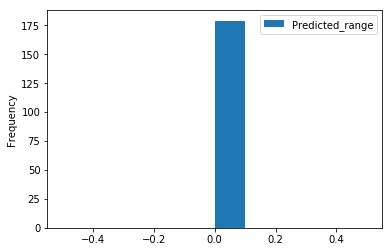

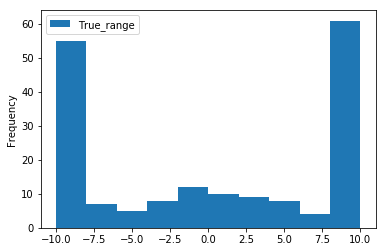

In [3]:
#compile together
name=['classification_ merge_EOS-USD.csv','classification_ merge_ZEC-USD.csv','classification_ merge_ETH-USD.csv','classification_ merge_XRP-USD.csv','classification_ merge_LTC-USD.csv']
#EOS
#load the data
X_train, Y_train, X_test, Y_test, window_length, dataset_total,split_line= load_data(name[0], 30,0.6880)

print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print(window_length)

#initialize the model
model = initialize_model(0.2)
print (model.summary())

#fit the model
model,history = fit_model(model, X_train, Y_train, 32, 100, .1)

#test the model
predictions=model_predictions(model, X_test, Y_test)
predictions.head(5)

#find the successful rate
successful_rate=find_the_successful_rate(predictions)
successful_rate


(639, 30, 112)
(639, 21)
(180, 30, 112)
(180, 21)
30
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 30, 32)            18560     
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 32)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 21)                693       
Total params: 27,573
Trainable params: 27,573
Non-trainable params: 0
_________________________________________________________________
None


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:110: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 575 samples, validate on 64 samples
Epoch 1/100
575/575 [==============================] - 6s 11ms/step - loss: 2.6326 - acc: 0.3043 - val_loss: 2.6309 - val_acc: 0.2656
Epoch 2/100
575/575 [==============================] - 1s 1ms/step - loss: 2.1358 - acc: 0.3652 - val_loss: 2.5673 - val_acc: 0.2656
Epoch 3/100
575/575 [==============================] - 1s 1ms/step - loss: 2.0181 - acc: 0.3409 - val_loss: 2.6039 - val_acc: 0.2656
Epoch 4/100
575/575 [==============================] - 1s 1ms/step - loss: 1.9932 - acc: 0.3635 - val_loss: 2.5852 - val_acc: 0.2656
Epoch 5/100
575/575 [==============================] - 1s 2ms/step - loss: 1.9879 - acc: 0.3548 - val_loss: 2.5677 - val_acc: 0.2656
Epoch 6/100
575/575 [==============================] - 1s 2ms/step - loss: 1.9814 - acc: 0.3722 - val_loss: 2.5619 - val_acc: 0.2656
Epoch 7/100
575/575 [==============================] - 1s 1ms/step - loss: 1.9655 - acc: 0.3670 - val_loss: 2.5510 - val_acc: 0.2656
Epoch 8/100
575/575 [==

Epoch 62/100
575/575 [==============================] - 0s 649us/step - loss: 1.8197 - acc: 0.4209 - val_loss: 2.4712 - val_acc: 0.3281
Epoch 63/100
575/575 [==============================] - 0s 624us/step - loss: 1.8258 - acc: 0.4157 - val_loss: 2.4420 - val_acc: 0.3281
Epoch 64/100
575/575 [==============================] - 0s 614us/step - loss: 1.8583 - acc: 0.4104 - val_loss: 2.4948 - val_acc: 0.3750
Epoch 65/100
575/575 [==============================] - 0s 609us/step - loss: 1.8041 - acc: 0.4383 - val_loss: 2.4147 - val_acc: 0.3594
Epoch 66/100
575/575 [==============================] - 0s 605us/step - loss: 1.8308 - acc: 0.4087 - val_loss: 2.5234 - val_acc: 0.3438
Epoch 67/100
575/575 [==============================] - 0s 624us/step - loss: 1.8350 - acc: 0.4330 - val_loss: 2.4207 - val_acc: 0.3438
Epoch 68/100
575/575 [==============================] - 0s 616us/step - loss: 1.8081 - acc: 0.4243 - val_loss: 2.5028 - val_acc: 0.3125
Epoch 69/100
575/575 [==========================

0.0333

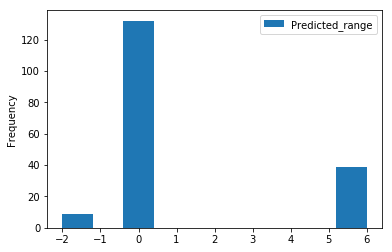

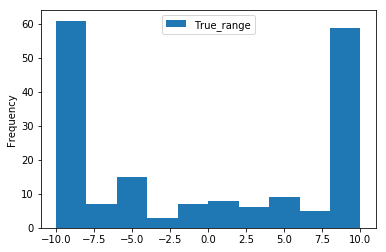

In [4]:
#compile together
#ZEC
name=['classification_ merge_EOS-USD.csv','classification_ merge_ZEC-USD.csv','classification_ merge_ETH-USD.csv','classification_ merge_XRP-USD.csv','classification_ merge_LTC-USD.csv']

#load the data
X_train, Y_train, X_test, Y_test, window_length, dataset_total,split_line= load_data(name[1], 30,0.7808)

print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print(window_length)

#initialize the model
model = initialize_model(0.2)
print (model.summary())

#fit the model
model,history = fit_model(model, X_train, Y_train, 32, 100, .1)

#test the model
predictions=model_predictions(model, X_test, Y_test)
predictions.head(5)

#find the successful rate
successful_rate=find_the_successful_rate(predictions)
successful_rate


(1087, 30, 110)
(1087, 21)
(180, 30, 110)
(180, 21)
30
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 30, 32)            18304     
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 32)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 21)                693       
Total params: 27,317
Trainable params: 27,317
Non-trainable params: 0
_________________________________________________________________
None


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:110: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 978 samples, validate on 109 samples
Epoch 1/100
978/978 [==============================] - 5s 5ms/step - loss: 2.5544 - acc: 0.3037 - val_loss: 2.5711 - val_acc: 0.2018
Epoch 2/100
978/978 [==============================] - 1s 1ms/step - loss: 2.2727 - acc: 0.3160 - val_loss: 2.5495 - val_acc: 0.2018
Epoch 3/100
978/978 [==============================] - 1s 1ms/step - loss: 2.2454 - acc: 0.3119 - val_loss: 2.5169 - val_acc: 0.2018
Epoch 4/100
978/978 [==============================] - 1s 1ms/step - loss: 2.2421 - acc: 0.3221 - val_loss: 2.4959 - val_acc: 0.2018
Epoch 5/100
978/978 [==============================] - 1s 1ms/step - loss: 2.2371 - acc: 0.3241 - val_loss: 2.4891 - val_acc: 0.2018
Epoch 6/100
978/978 [==============================] - 1s 1ms/step - loss: 2.2404 - acc: 0.3027 - val_loss: 2.4888 - val_acc: 0.2018
Epoch 7/100
978/978 [==============================] - 1s 987us/step - loss: 2.2353 - acc: 0.3231 - val_loss: 2.4914 - val_acc: 0.2294
Epoch 8/100
978/978 [

978/978 [==============================] - 1s 1ms/step - loss: 2.0603 - acc: 0.3620 - val_loss: 2.5708 - val_acc: 0.2294
Epoch 62/100
978/978 [==============================] - 1s 1ms/step - loss: 2.0618 - acc: 0.3630 - val_loss: 2.5710 - val_acc: 0.2477
Epoch 63/100
978/978 [==============================] - 1s 1ms/step - loss: 2.0727 - acc: 0.3620 - val_loss: 2.5580 - val_acc: 0.2202
Epoch 64/100
978/978 [==============================] - 1s 1ms/step - loss: 2.0555 - acc: 0.3681 - val_loss: 2.5481 - val_acc: 0.2294
Epoch 65/100
978/978 [==============================] - 1s 1ms/step - loss: 2.0419 - acc: 0.3548 - val_loss: 2.6114 - val_acc: 0.2202
Epoch 66/100
978/978 [==============================] - 1s 1ms/step - loss: 2.0703 - acc: 0.3630 - val_loss: 2.5684 - val_acc: 0.2202
Epoch 67/100
978/978 [==============================] - 1s 1ms/step - loss: 2.0542 - acc: 0.3691 - val_loss: 2.5913 - val_acc: 0.2477
Epoch 68/100
978/978 [==============================] - 1s 1ms/step - loss:

0.0833

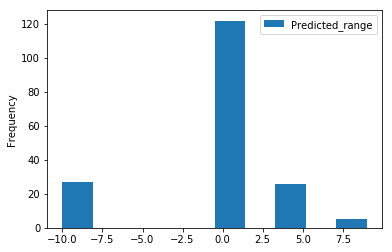

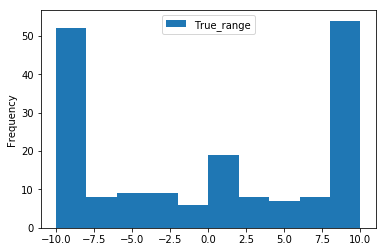

In [5]:
#compile together
#ETH
name=['classification_ merge_EOS-USD.csv','classification_ merge_ZEC-USD.csv','classification_ merge_ETH-USD.csv','classification_ merge_XRP-USD.csv','classification_ merge_LTC-USD.csv']

#load the data
X_train, Y_train, X_test, Y_test, window_length, dataset_total,split_line= load_data(name[2], 30,0.8582)

print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print(window_length)

#initialize the model
model = initialize_model(0.2)
print (model.summary())

#fit the model
model,history = fit_model(model, X_train, Y_train, 32, 100, .1)

#test the model
predictions=model_predictions(model, X_test, Y_test)
predictions.head(5)

#find the successful rate
successful_rate=find_the_successful_rate(predictions)
successful_rate


(1285, 30, 110)
(1285, 21)
(180, 30, 110)
(180, 21)
30
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 30, 32)            18304     
_________________________________________________________________
dropout_7 (Dropout)          (None, 30, 32)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 21)                693       
Total params: 27,317
Trainable params: 27,317
Non-trainable params: 0
_________________________________________________________________
None


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:110: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 1156 samples, validate on 129 samples
Epoch 1/100
1156/1156 [==============================] - 5s 4ms/step - loss: 2.3960 - acc: 0.3166 - val_loss: 2.2803 - val_acc: 0.3178
Epoch 2/100
1156/1156 [==============================] - 1s 1ms/step - loss: 2.2296 - acc: 0.3028 - val_loss: 2.2445 - val_acc: 0.3178
Epoch 3/100
1156/1156 [==============================] - 1s 1ms/step - loss: 2.2043 - acc: 0.3054 - val_loss: 2.2458 - val_acc: 0.3178
Epoch 4/100
1156/1156 [==============================] - 1s 1ms/step - loss: 2.1949 - acc: 0.3330 - val_loss: 2.2455 - val_acc: 0.3178
Epoch 5/100
1156/1156 [==============================] - 1s 1ms/step - loss: 2.1999 - acc: 0.3010 - val_loss: 2.2451 - val_acc: 0.3178
Epoch 6/100
1156/1156 [==============================] - 1s 1ms/step - loss: 2.1805 - acc: 0.2993 - val_loss: 2.2473 - val_acc: 0.3178
Epoch 7/100
1156/1156 [==============================] - 1s 1ms/step - loss: 2.1814 - acc: 0.2941 - val_loss: 2.2746 - val_acc: 0.3178
Epoch 8/

Epoch 61/100
1156/1156 [==============================] - 1s 749us/step - loss: 1.9723 - acc: 0.3521 - val_loss: 2.4246 - val_acc: 0.3178
Epoch 62/100
1156/1156 [==============================] - 1s 672us/step - loss: 1.9624 - acc: 0.3676 - val_loss: 2.4309 - val_acc: 0.3178
Epoch 63/100
1156/1156 [==============================] - 1s 859us/step - loss: 1.9610 - acc: 0.3478 - val_loss: 2.4090 - val_acc: 0.3178
Epoch 64/100
1156/1156 [==============================] - 1s 1ms/step - loss: 1.9412 - acc: 0.3460 - val_loss: 2.3835 - val_acc: 0.3178
Epoch 65/100
1156/1156 [==============================] - 1s 849us/step - loss: 1.9335 - acc: 0.3581 - val_loss: 2.3782 - val_acc: 0.3178
Epoch 66/100
1156/1156 [==============================] - 1s 1ms/step - loss: 1.9529 - acc: 0.3356 - val_loss: 2.4201 - val_acc: 0.3178
Epoch 67/100
1156/1156 [==============================] - 1s 1ms/step - loss: 1.9401 - acc: 0.3503 - val_loss: 2.4361 - val_acc: 0.3178
Epoch 68/100
1156/1156 [================

0.0389

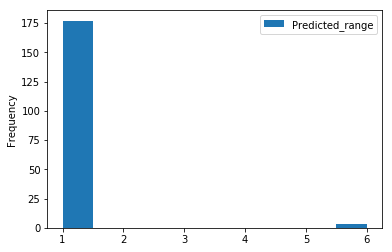

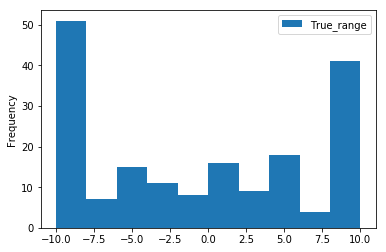

In [6]:
#compile together
#XRP
name=['classification_ merge_EOS-USD.csv','classification_ merge_ZEC-USD.csv','classification_ merge_ETH-USD.csv','classification_ merge_XRP-USD.csv','classification_ merge_LTC-USD.csv']

#load the data
X_train, Y_train, X_test, Y_test, window_length, dataset_total,split_line= load_data(name[3], 30,0.8773)

print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print(window_length)

#initialize the model
model = initialize_model(0.2)
print (model.summary())

#fit the model
model,history = fit_model(model, X_train, Y_train, 32, 100, .1)

#test the model
predictions=model_predictions(model, X_test, Y_test)
predictions.head(5)

#find the successful rate
successful_rate=find_the_successful_rate(predictions)
successful_rate


(1739, 30, 108)
(1739, 21)
(180, 30, 108)
(180, 21)
30
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 30, 32)            18048     
_________________________________________________________________
dropout_9 (Dropout)          (None, 30, 32)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_10 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 21)                693       
Total params: 27,061
Trainable params: 27,061
Non-trainable params: 0
_________________________________________________________________
None


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:110: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 1565 samples, validate on 174 samples
Epoch 1/100
1565/1565 [==============================] - 8s 5ms/step - loss: 2.7233 - acc: 0.2083 - val_loss: 2.4737 - val_acc: 0.3103
Epoch 2/100
1565/1565 [==============================] - 2s 1ms/step - loss: 2.5433 - acc: 0.2288 - val_loss: 2.4563 - val_acc: 0.3103
Epoch 3/100
1565/1565 [==============================] - 2s 1ms/step - loss: 2.5242 - acc: 0.2409 - val_loss: 2.4416 - val_acc: 0.3103
Epoch 4/100
1565/1565 [==============================] - 2s 1ms/step - loss: 2.4941 - acc: 0.2377 - val_loss: 2.4893 - val_acc: 0.3103
Epoch 5/100
1565/1565 [==============================] - 2s 1ms/step - loss: 2.4725 - acc: 0.2339 - val_loss: 2.5259 - val_acc: 0.2184
Epoch 6/100
1565/1565 [==============================] - 2s 1ms/step - loss: 2.4665 - acc: 0.2179 - val_loss: 2.5067 - val_acc: 0.2184
Epoch 7/100
1565/1565 [==============================] - 2s 1ms/step - loss: 2.4487 - acc: 0.2383 - val_loss: 2.5150 - val_acc: 0.2184
Epoch 8/

Epoch 61/100
1565/1565 [==============================] - 2s 1ms/step - loss: 2.1864 - acc: 0.2939 - val_loss: 2.5293 - val_acc: 0.2184
Epoch 62/100
1565/1565 [==============================] - 2s 1ms/step - loss: 2.1669 - acc: 0.3035 - val_loss: 2.5361 - val_acc: 0.2184
Epoch 63/100
1565/1565 [==============================] - 2s 1ms/step - loss: 2.1694 - acc: 0.3093 - val_loss: 2.5434 - val_acc: 0.2184
Epoch 64/100
1565/1565 [==============================] - 2s 1ms/step - loss: 2.1476 - acc: 0.3201 - val_loss: 2.5717 - val_acc: 0.2184
Epoch 65/100
1565/1565 [==============================] - 1s 792us/step - loss: 2.1465 - acc: 0.3099 - val_loss: 2.5348 - val_acc: 0.2184
Epoch 66/100
1565/1565 [==============================] - 1s 760us/step - loss: 2.1509 - acc: 0.3137 - val_loss: 2.5599 - val_acc: 0.2184
Epoch 67/100
1565/1565 [==============================] - 1s 722us/step - loss: 2.1371 - acc: 0.3029 - val_loss: 2.5329 - val_acc: 0.2184
Epoch 68/100
1565/1565 [==================

0.0222

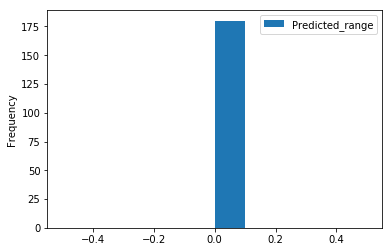

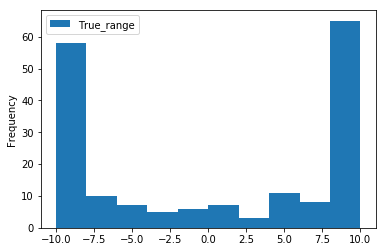

In [7]:
#compile together
#LTC
name=['classification_ merge_EOS-USD.csv','classification_ merge_ZEC-USD.csv','classification_ merge_ETH-USD.csv','classification_ merge_XRP-USD.csv','classification_ merge_LTC-USD.csv']

#load the data
X_train, Y_train, X_test, Y_test, window_length, dataset_total,split_line= load_data(name[4], 30,0.9063)

print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print(window_length)

#initialize the model
model = initialize_model(0.2)
print (model.summary())

#fit the model
model,history = fit_model(model, X_train, Y_train, 32, 100, .1)

#test the model
predictions=model_predictions(model, X_test, Y_test)
predictions.head(5)

#find the successful rate
successful_rate=find_the_successful_rate(predictions)
successful_rate


(2934, 30, 106)
(2934, 21)
(180, 30, 106)
(180, 21)
30
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 30, 32)            17792     
_________________________________________________________________
dropout_15 (Dropout)         (None, 30, 32)            0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_16 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 21)                693       
Total params: 26,805
Trainable params: 26,805
Non-trainable params: 0
_________________________________________________________________
None


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:110: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 2640 samples, validate on 294 samples
Epoch 1/100
2640/2640 [==============================] - 4s 2ms/step - loss: 2.6266 - acc: 0.2561 - val_loss: 2.6621 - val_acc: 0.1939
Epoch 2/100
2640/2640 [==============================] - 2s 581us/step - loss: 2.5267 - acc: 0.2545 - val_loss: 2.6782 - val_acc: 0.1939
Epoch 3/100
2640/2640 [==============================] - 2s 622us/step - loss: 2.5057 - acc: 0.2640 - val_loss: 2.8125 - val_acc: 0.1939
Epoch 4/100
2640/2640 [==============================] - 2s 639us/step - loss: 2.5044 - acc: 0.2667 - val_loss: 2.7845 - val_acc: 0.1939
Epoch 5/100
2640/2640 [==============================] - 2s 647us/step - loss: 2.4794 - acc: 0.2678 - val_loss: 2.8455 - val_acc: 0.1939
Epoch 6/100
2640/2640 [==============================] - 2s 575us/step - loss: 2.4783 - acc: 0.2693 - val_loss: 2.9074 - val_acc: 0.1939
Epoch 7/100
2640/2640 [==============================] - 2s 572us/step - loss: 2.4606 - acc: 0.2739 - val_loss: 2.8710 - val_acc: 0.2

2640/2640 [==============================] - 2s 823us/step - loss: 2.2401 - acc: 0.3254 - val_loss: 2.8884 - val_acc: 0.1871
Epoch 61/100
2640/2640 [==============================] - 2s 806us/step - loss: 2.2462 - acc: 0.3208 - val_loss: 2.8781 - val_acc: 0.1905
Epoch 62/100
2640/2640 [==============================] - 2s 634us/step - loss: 2.2389 - acc: 0.3125 - val_loss: 2.9362 - val_acc: 0.2109
Epoch 63/100
2640/2640 [==============================] - 2s 708us/step - loss: 2.2278 - acc: 0.3133 - val_loss: 3.0824 - val_acc: 0.1871
Epoch 64/100
2640/2640 [==============================] - 2s 670us/step - loss: 2.2380 - acc: 0.3201 - val_loss: 2.9088 - val_acc: 0.2007
Epoch 65/100
2640/2640 [==============================] - 2s 649us/step - loss: 2.2168 - acc: 0.3163 - val_loss: 2.9433 - val_acc: 0.1973
Epoch 66/100
2640/2640 [==============================] - 2s 660us/step - loss: 2.2140 - acc: 0.3121 - val_loss: 2.9354 - val_acc: 0.1905
Epoch 67/100
2640/2640 [=======================

0.0889

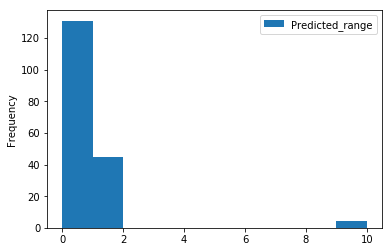

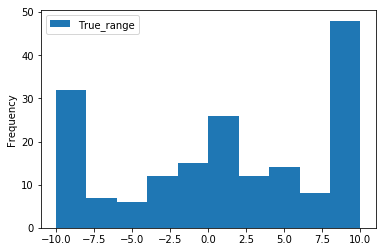

In [10]:
#load the data
X_train, Y_train, X_test, Y_test, window_length, dataset_total,split_line= load_data('Classification_bitcoin.csv', 30,0.9422)

print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print(window_length)

#initialize the model
model = initialize_model(0.2)
print (model.summary())

#fit the model
model,history = fit_model(model, X_train, Y_train, 32, 100, .1)

#test the model
predictions=model_predictions(model, X_test, Y_test)
predictions.head(5)

#find the successful rate
successful_rate=find_the_successful_rate(predictions)
successful_rate
